## Sentiment Analysis with Transformers and NLTK

### 1. VADER(Valeence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
### 2. Roberta Pretrained Model - Transformer based approach
### 3. Huggingface Pipeline - Transformer based approach

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk 


In [139]:
df = pd.read_csv('Reviews.csv')

In [140]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [141]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [142]:
df.shape

(568454, 10)

In [143]:
# scalling down the data to 1000 rows for faster processing
df = df.head(1000)
df.shape

(1000, 10)

### EDA

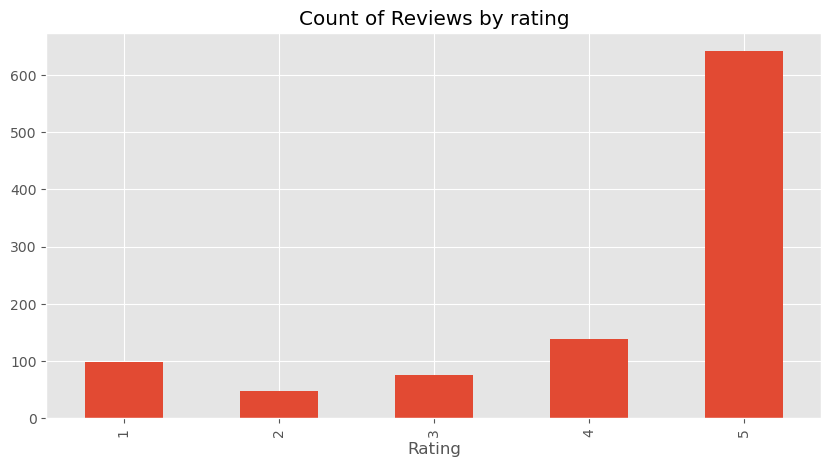

In [144]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by rating', figsize=(10, 5))
ax.set_xlabel('Rating')
plt.show()

### Basic NLTK

In [145]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [146]:
# tokenization
tokens = nltk.word_tokenize(example)
print(tokens[:10])

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']


In [147]:
# POS tagging
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')
tagged = nltk.pos_tag(tokens)
print(tagged[:10])

[('This', 'DT'), ('oatmeal', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.'), ('Its', 'PRP$'), ('mushy', 'NN'), (',', ','), ('soft', 'JJ')]


In [148]:
# Named entity recognition
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('maxent_ne_chunker_tab')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1. VADER Sentiment Analysis
### Use NLTK's SentimentIntensityAnalyzer to get the negative, neutral, positive scores of the text
#### This uses a "bag of words" approach to determine the sentiment of the text:
1. Stop words are removed.
2. Each word is scored and combined to a total score.

In [149]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Download the vader_lexicon resource
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [150]:
# Test SentimentIntensityAnalyzer
print(sia.polarity_scores(example))
print(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}
This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [151]:
# Run the Polarity Score on all the dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)   

  0%|          | 0/1000 [00:00<?, ?it/s]

In [152]:
# add sentiment scores to the metadata
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot VADER Sentiment Analysis

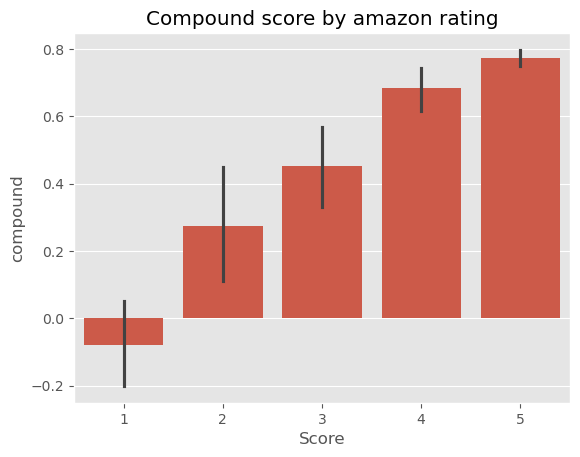

In [153]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound score by amazon rating')
plt.show()

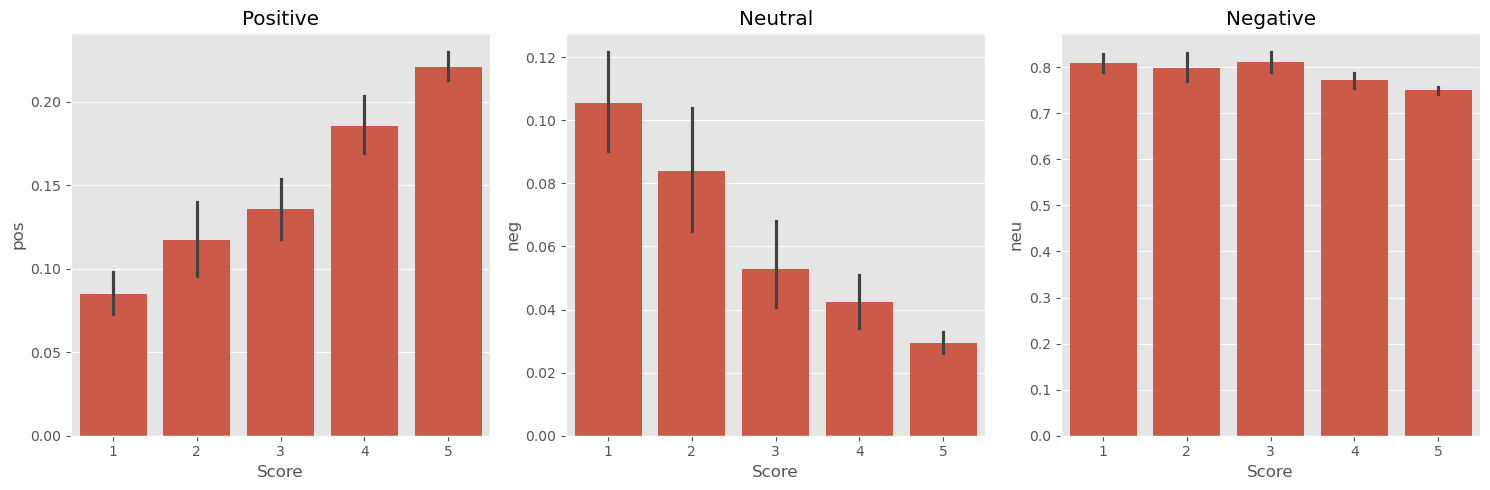

In [154]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Roberta Pretrained Model
##### use a model trained on a large corpus of data
##### Tranformer model account for the words and also the context of the words in the sentence.

In [155]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [156]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [157]:
# VADER result on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [158]:
# Run for Reberta model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.0029573722}


In [159]:
def polarity_scores_reberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [160]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value


        roberta_result = polarity_scores_reberta(text)
        both = vader_result_rename | roberta_result
        res[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [161]:
result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns={'index': 'Id'})
result_df = result_df.merge(df, how='left')

In [162]:
result_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Compare Scores of Vader and Reberta

In [163]:
result_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

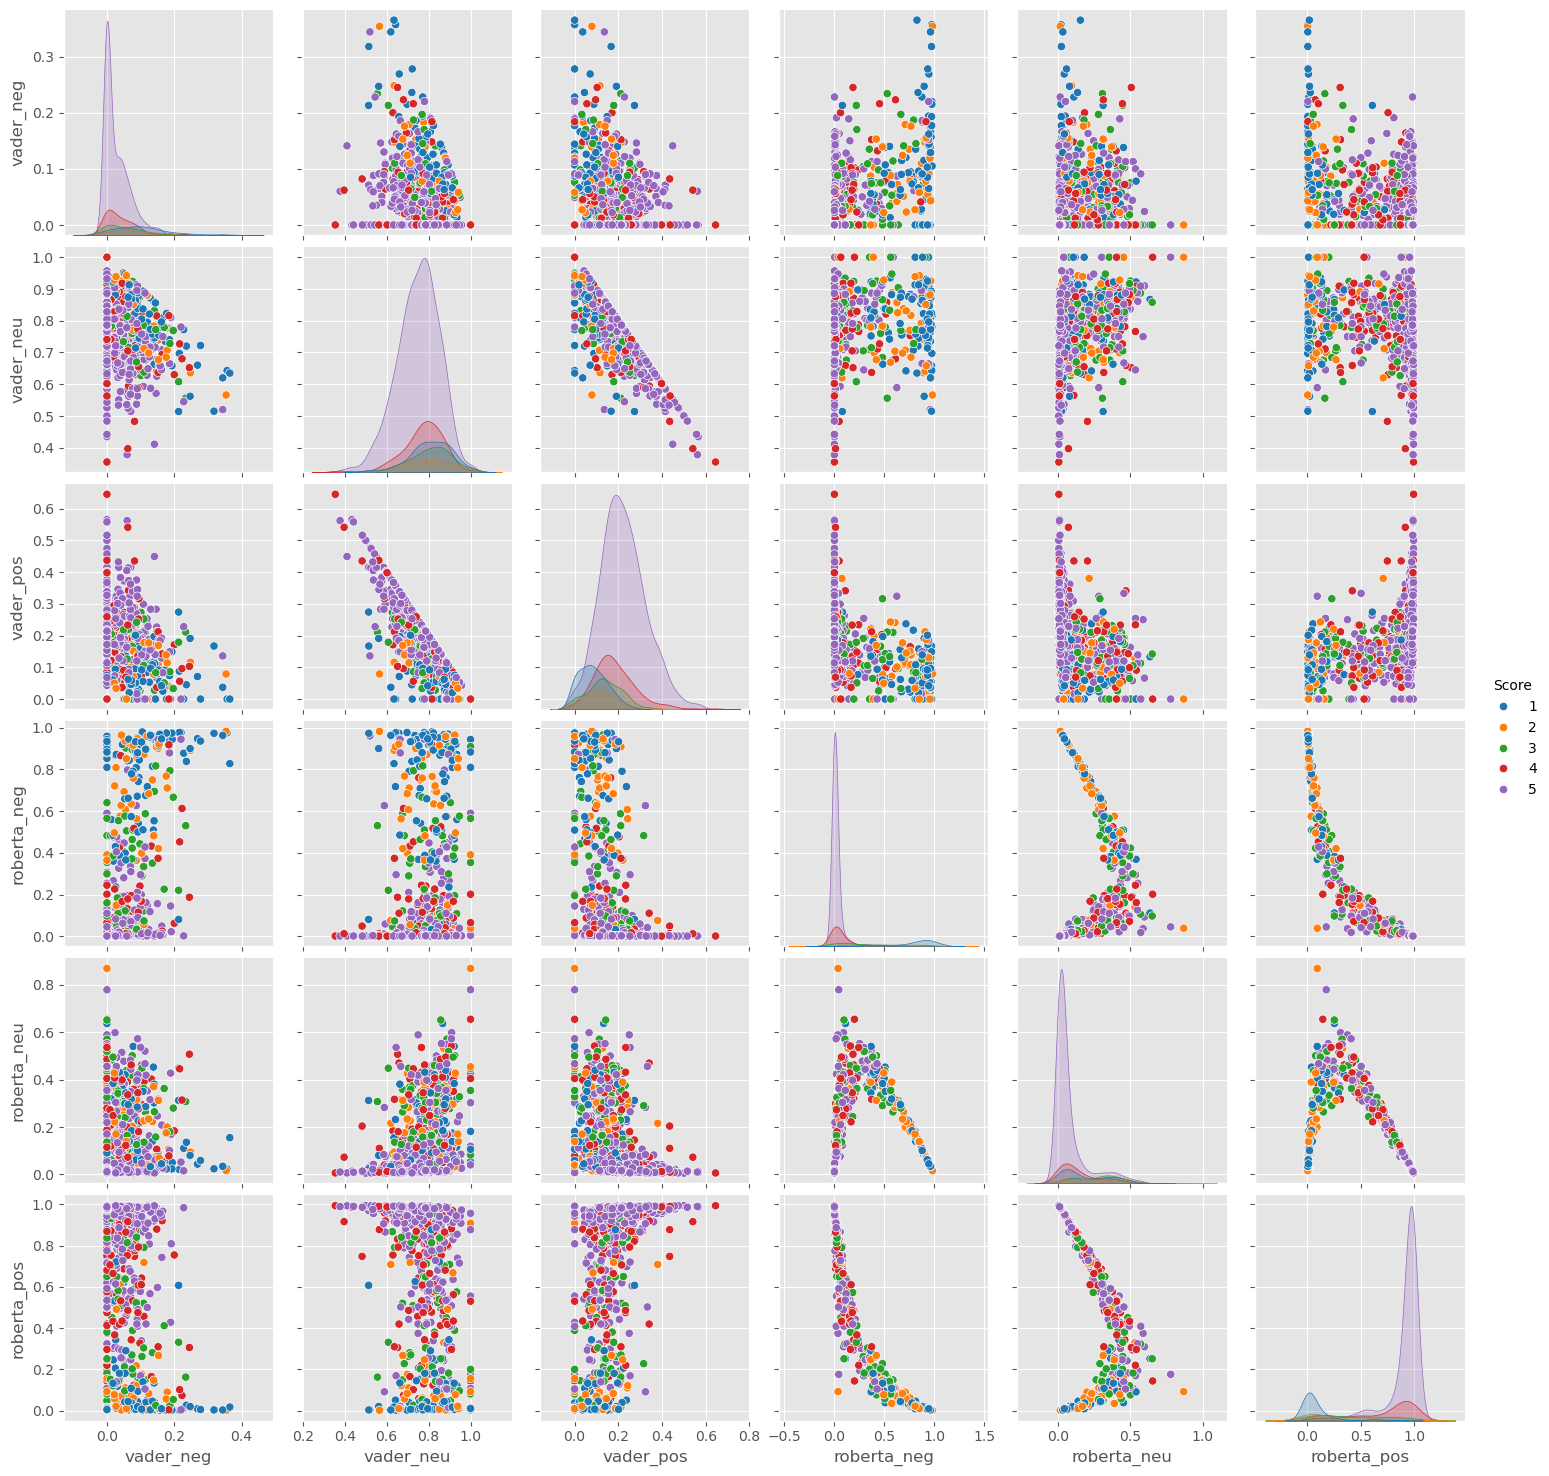

In [164]:
# compile and compare
sns.pairplot(data=result_df,
                vars = ['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
                hue='Score',
                palette='tab10'
                )
plt.show()

            

### Review Examples

In [165]:
result_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [166]:
# negative review with 5 stars
result_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [167]:
result_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Transformers Pipeline

In [168]:
from transformers import pipeline

sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [169]:
sent_pipeline('I love sentiment analysis') 

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [170]:
# sentiment analysis with Transformers pipeline
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        pipeline_result = sent_pipeline(text)
        res[myid] = pipeline_result
    except RuntimeError:
        print(f"Broke for id {myid}")


  0%|          | 0/1000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 866


In [171]:
result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns={'index': 'Id'})
result_df

,Id,0
0,1,"{'label': 'POSITIVE', 'score': 0.9983851909637..."
1,2,"{'label': 'NEGATIVE', 'score': 0.9995254278182..."
2,3,"{'label': 'POSITIVE', 'score': 0.9997652173042..."
3,4,"{'label': 'POSITIVE', 'score': 0.9991534948348..."
4,5,"{'label': 'POSITIVE', 'score': 0.9987082481384..."
...,...,...
988,996,"{'label': 'POSITIVE', 'score': 0.9997904896736..."
989,997,"{'label': 'POSITIVE', 'score': 0.8036794066429..."
990,998,"{'label': 'POSITIVE', 'score': 0.9995176792144..."
991,999,"{'label': 'NEGATIVE', 'score': 0.9975288510322..."
